In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr


%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

/var/folders/sp/fwzd_0y9239d2sc9ryng4khh0000gp/T/ipykernel_3791/2916246244.py:8: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


In [5]:
train = pd.read_csv('../data/eleicoes_2006_filtered.csv')
test = pd.read_csv('../data/eleicoes_2010_filtered.csv')

test.head()

,ano,sequencial_candidato,nome,uf,partido,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos/comites,...,quantidade_despesas,quantidade_fornecedores,total_despesa,media_despesa,cargo,sexo,grau,estado_civil,ocupacao,votos
0,2010,10000000194,ANTONIA LUCILEIA CRUZ RAMOS CAMARA,AC,PSC,36,35,406891.92,116.254.834.285.714,269179.61,...,54,48,381881.55,7.955.865.625,DEPUTADO FEDERAL,FEMININO,SUPERIOR COMPLETO,CASADO(A),EMPRESÁRIO,15849
1,2010,10000000195,DEODATO NUNES DE FRANÇA,AC,PMDB,3,3,6990,2330,NaN,...,3,3,6990.00,2330,DEPUTADO FEDERAL,MASCULINO,SUPERIOR COMPLETO,CASADO(A),OUTROS,4620
2,2010,10000000196,EDSON FIRMINO DE PAULA,AC,PSDB,3,3,1840,613.333.333.333.333,290,...,3,3,1840.00,613.333.333.333.333,DEPUTADO FEDERAL,MASCULINO,SUPERIOR INCOMPLETO,CASADO(A),"OPERADOR DE EQUIPAMENTO DE RÁDIO, TELEVISÃO, S...",312
3,2010,10000000197,ELISABETH APARECIDA GARCIA RODRIGUES,AC,PSDB,1,1,440,440,440,...,1,1,440.00,440,DEPUTADO FEDERAL,FEMININO,SUPERIOR COMPLETO,CASADO(A),PROFESSOR DE ENSINO MÉDIO,1357
4,2010,10000000198,FLAVIANO FLAVIO BAPTISTA DE MELO,AC,PMDB,15,13,241500,185.769.230.769.231,NaN,...,83,59,232677.64,394.368.881.355.932,DEPUTADO FEDERAL,MASCULINO,SUPERIOR COMPLETO,DIVORCIADO(A),DEPUTADO,36301


In [6]:
all_data = pd.concat((train.loc[:,'partido':'votos'],
                      test.loc[:,'partido':'votos']))

array([[<AxesSubplot: title={'center': 'votos_computados'}>,
        <AxesSubplot: title={'center': 'log(votos + 1)'}>]], dtype=object)

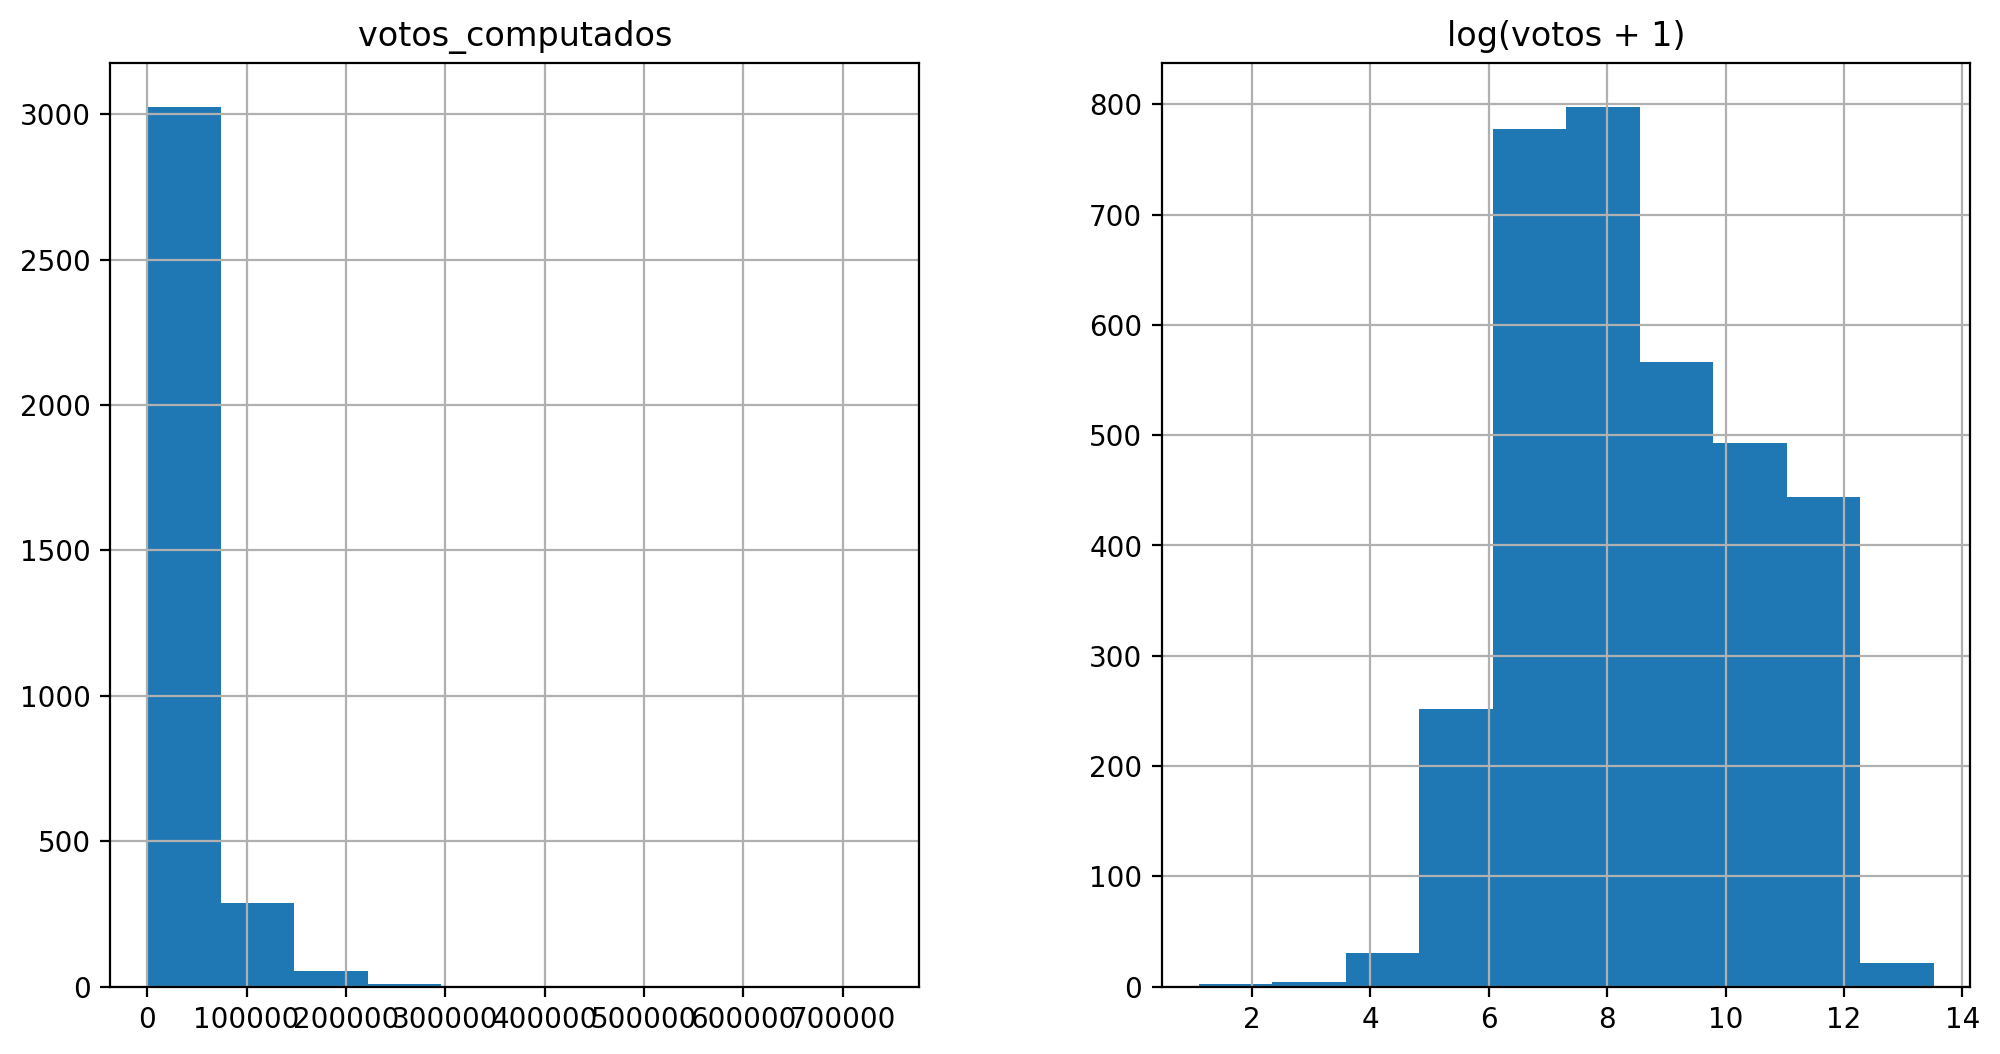

In [7]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
votos = pd.DataFrame({"votos_computados":train["votos"], "log(votos + 1)":np.log1p(train["votos"])})
votos.hist()

In [8]:
#log transform the target:
train["votos"] = np.log1p(train["votos"])

#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [9]:
all_data = pd.get_dummies(all_data)

In [11]:
#creating matrices for sklearn:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.votos

In [12]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [13]:
model_ridge = Ridge()

In [14]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

Text(0, 0.5, 'rmse')

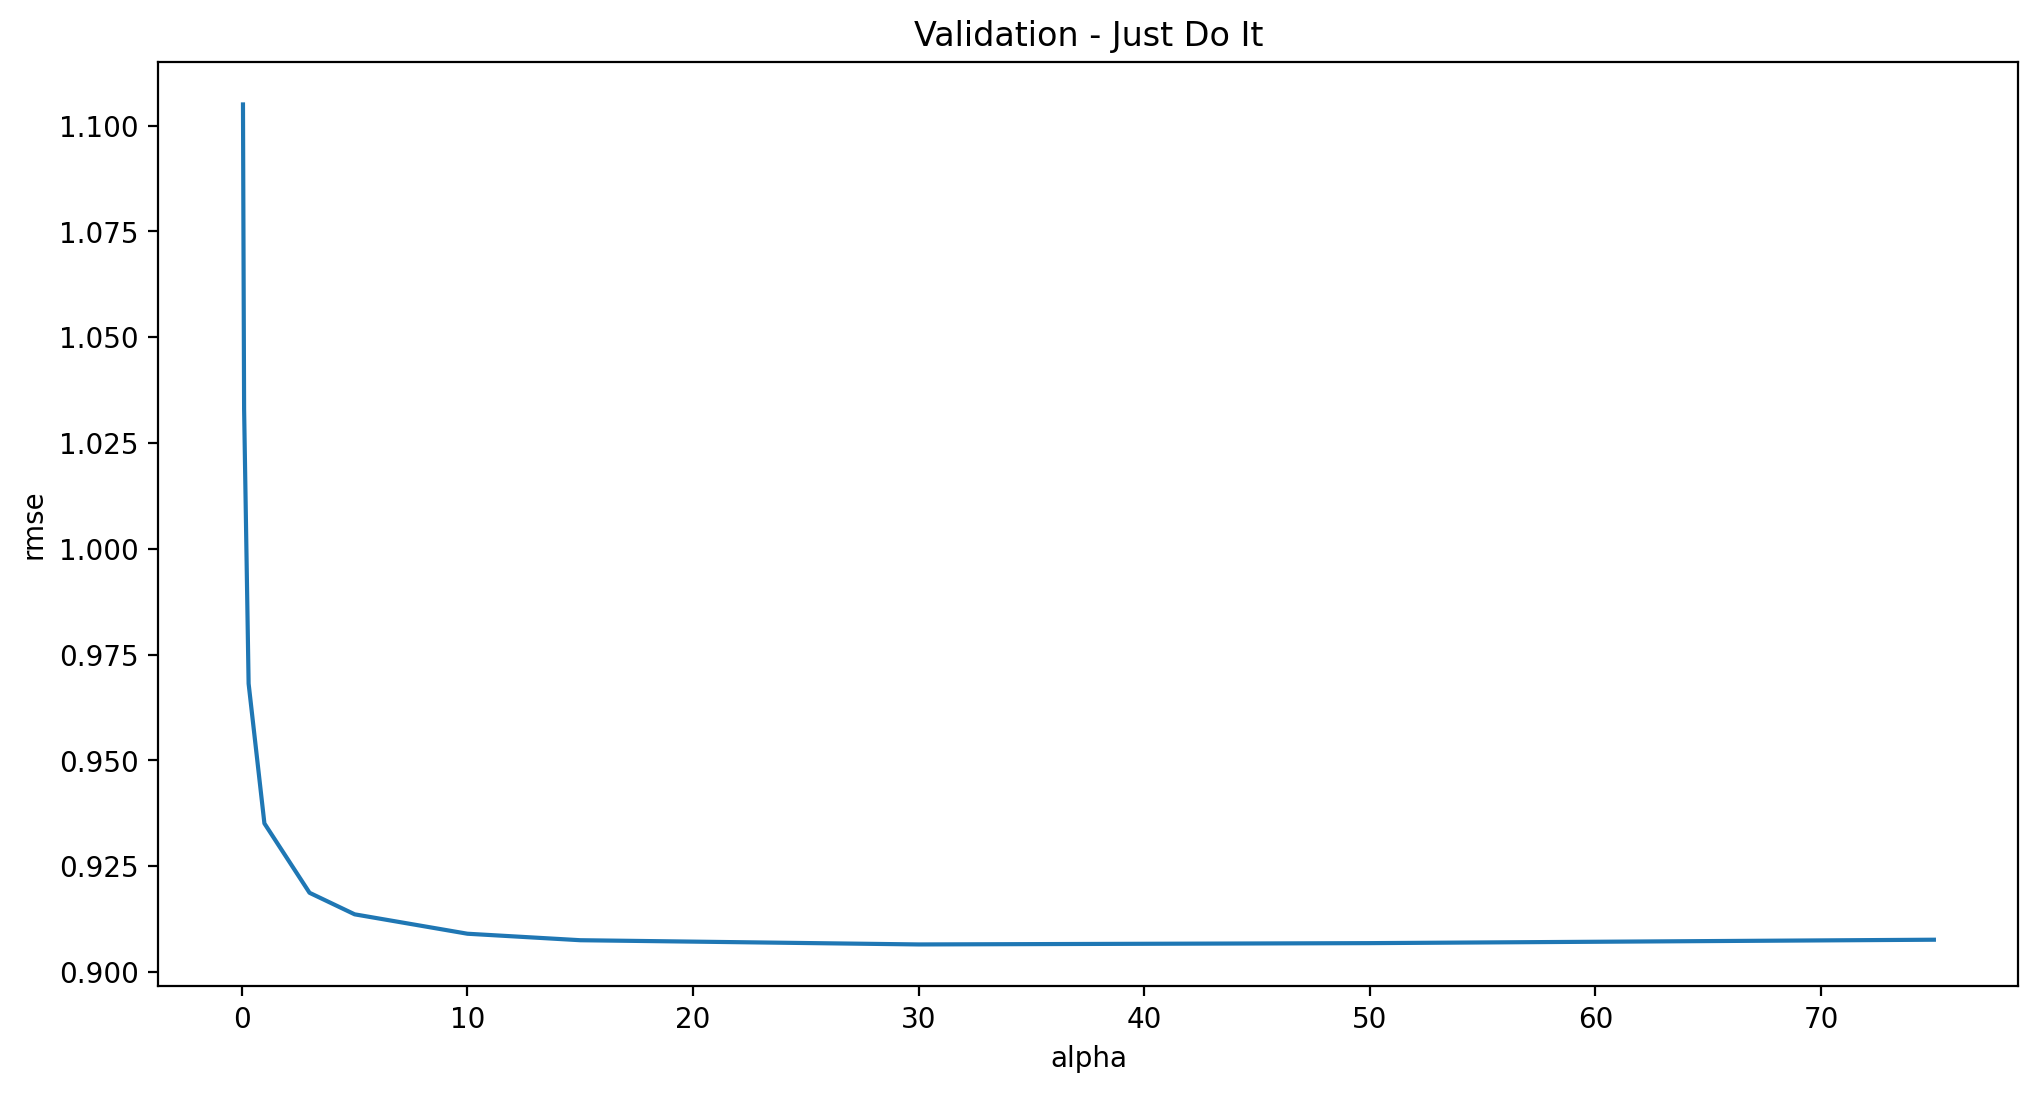

In [15]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [16]:
cv_ridge.min()

0.9064872394402299

In [17]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.572e+00, tolerance: 9.862e-01
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.134e+01, tolerance: 9.862e-01
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

In [18]:
rmse_cv(model_lasso).mean()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.641e+00, tolerance: 7.652e-01
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.149e+02, tolerance: 7.652e-01
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

0.9102940855506259

In [20]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)

In [21]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 189 variables and eliminated the other 30030 variables


In [22]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

Text(0.5, 1.0, 'Coefficients in the Lasso Model')

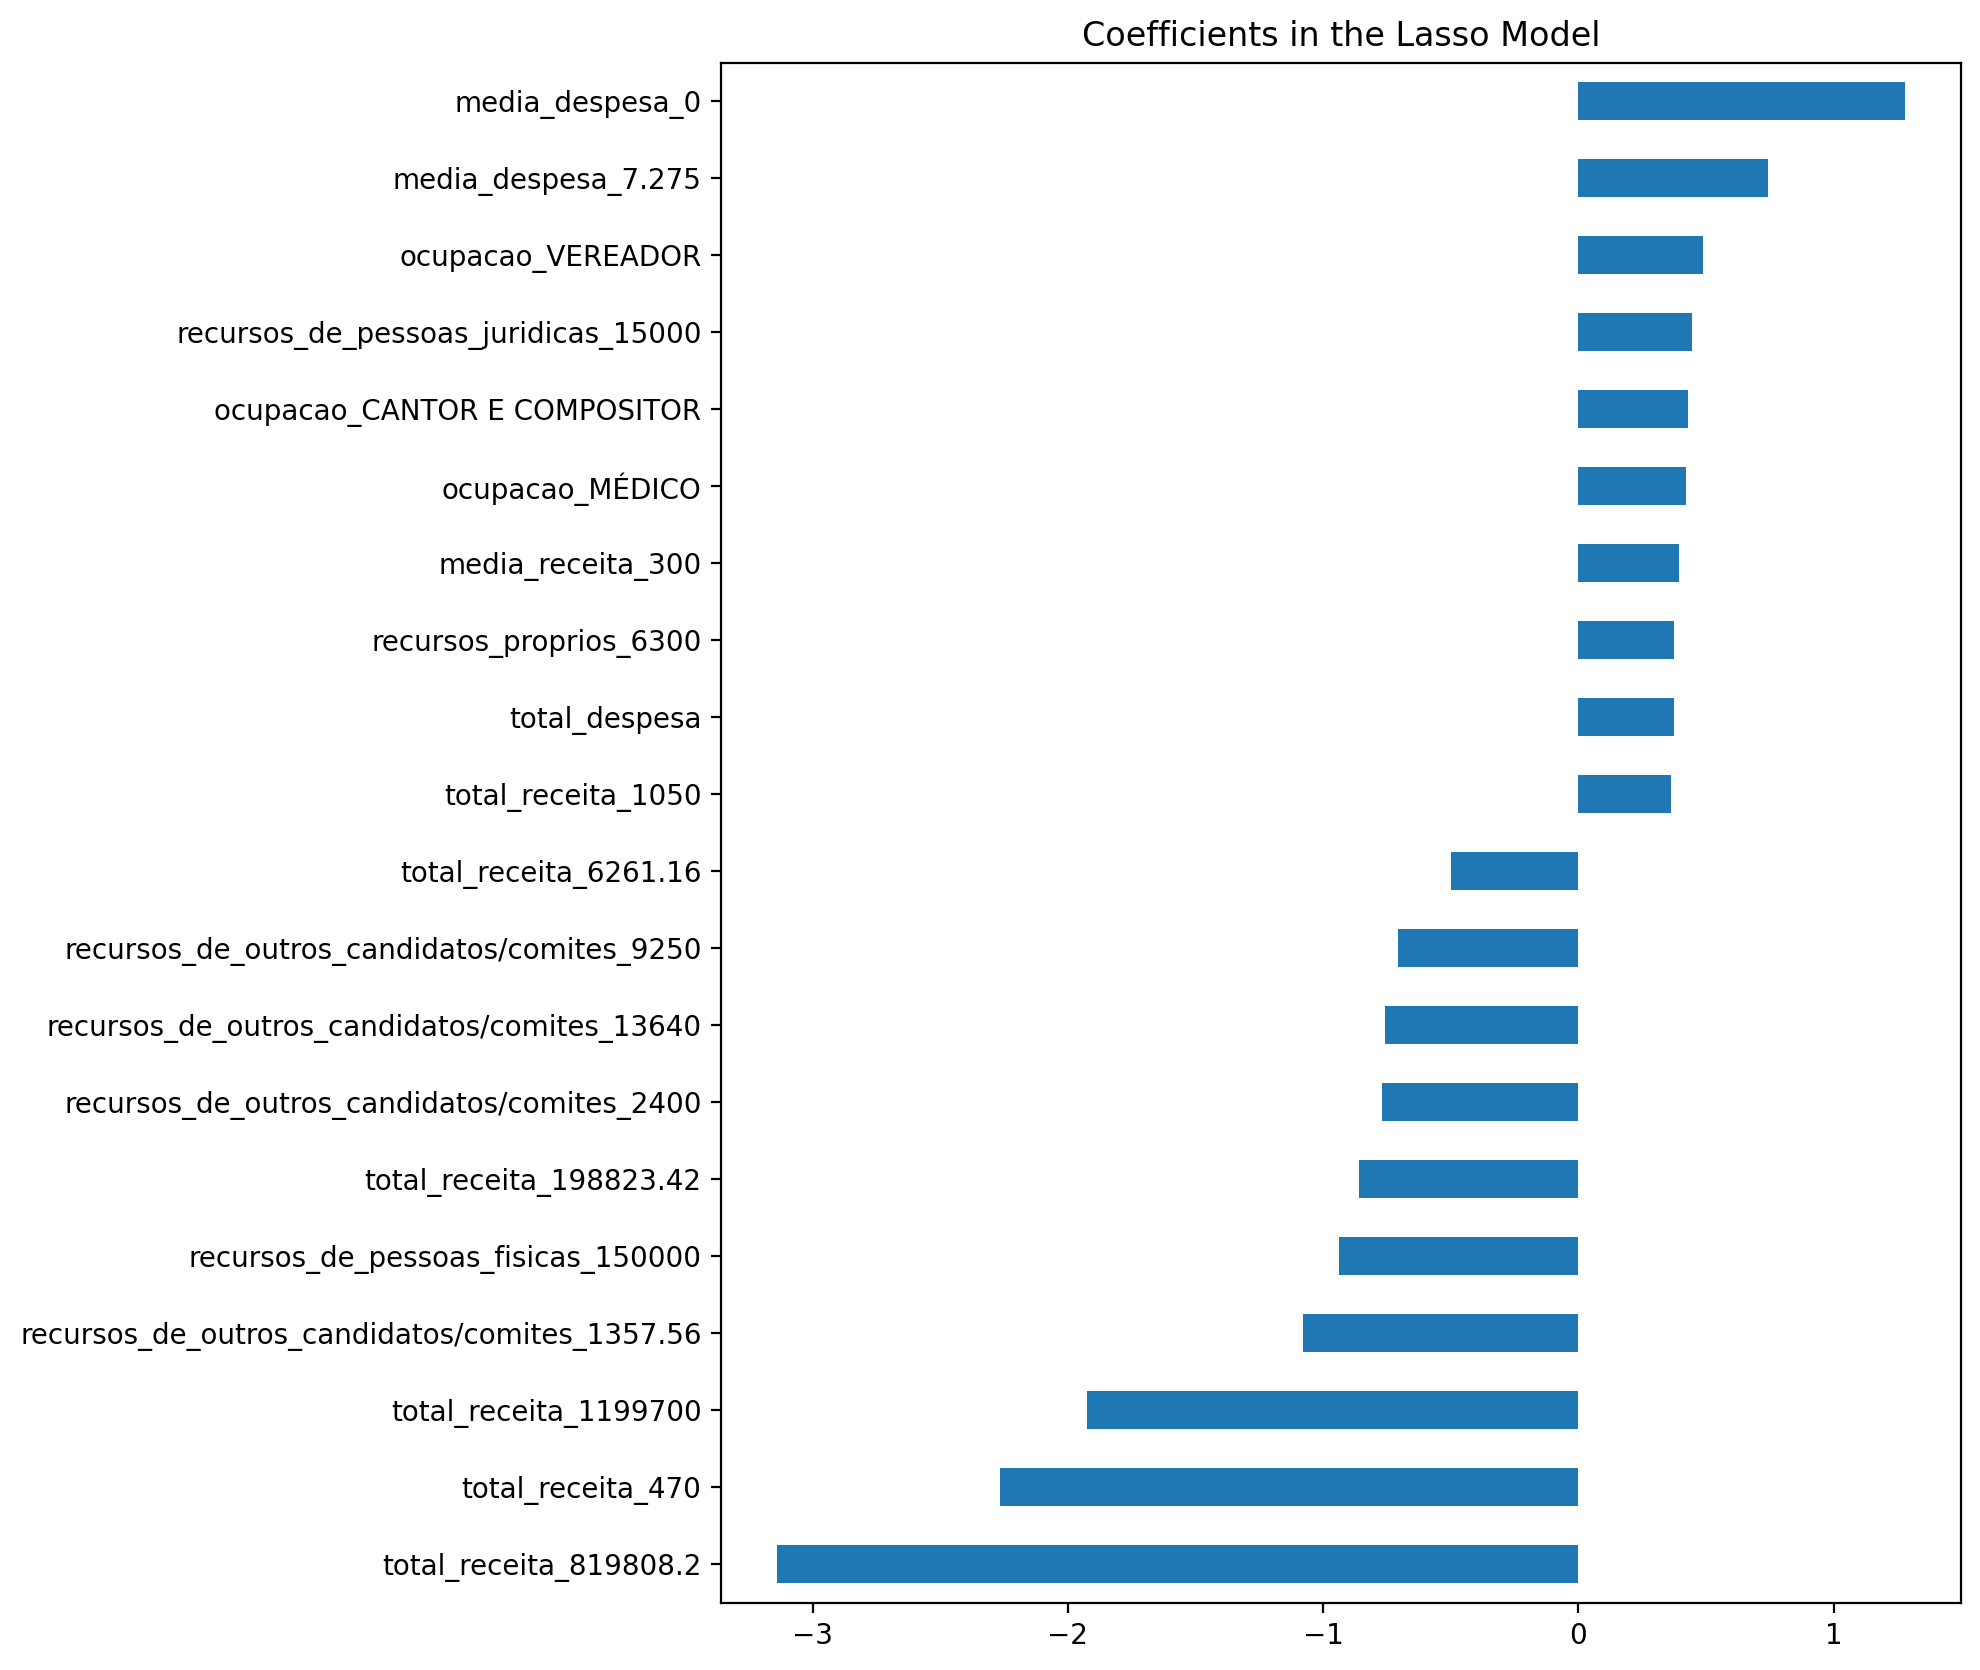

In [23]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

<AxesSubplot: xlabel='preds', ylabel='residuals'>

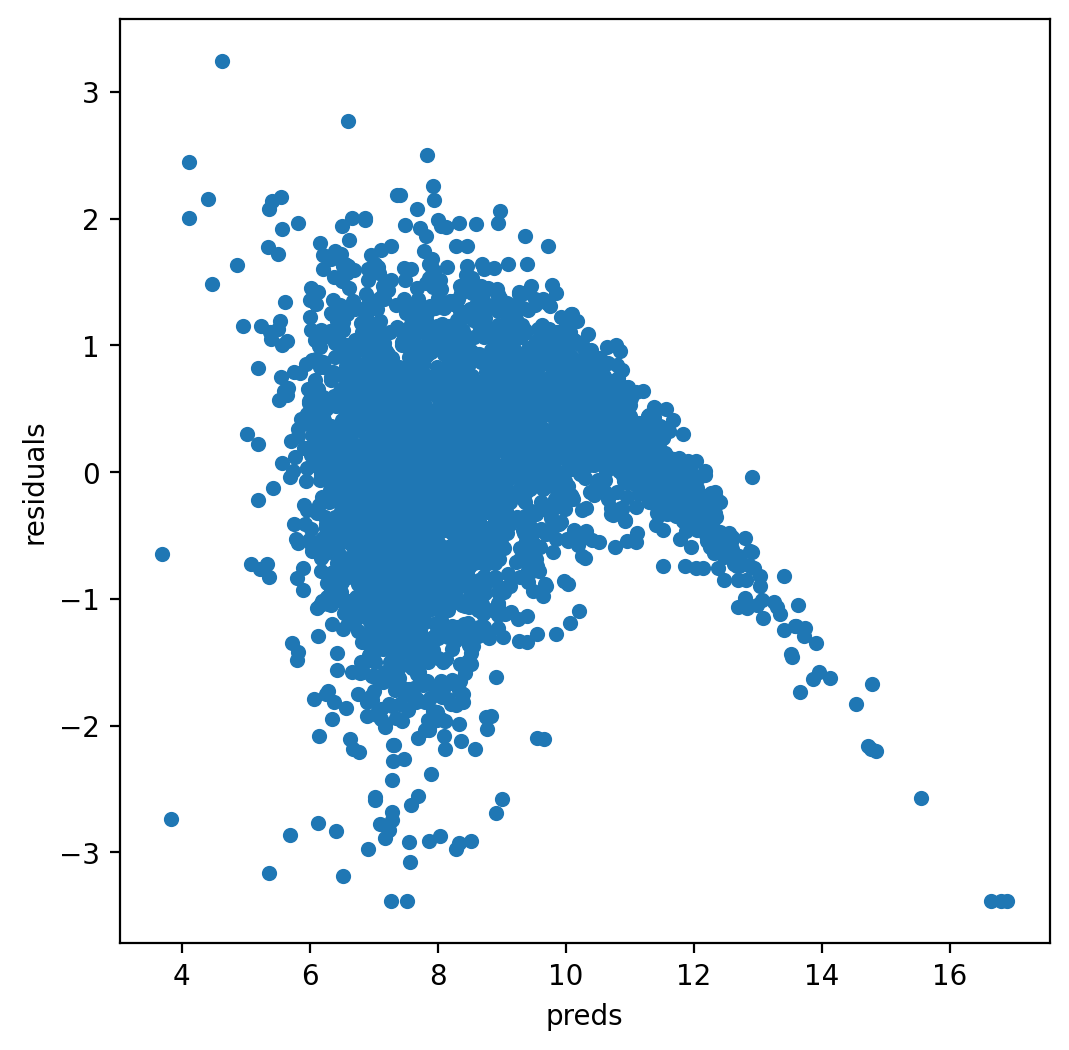

In [24]:
#let's look at the residuals as well:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_lasso.predict(X_train), "true":y})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

In [25]:
import xgboost as xgb

In [26]:
dtrain = xgb.DMatrix(X_train, label = y)
dtest = xgb.DMatrix(X_test)

params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)


<AxesSubplot: >

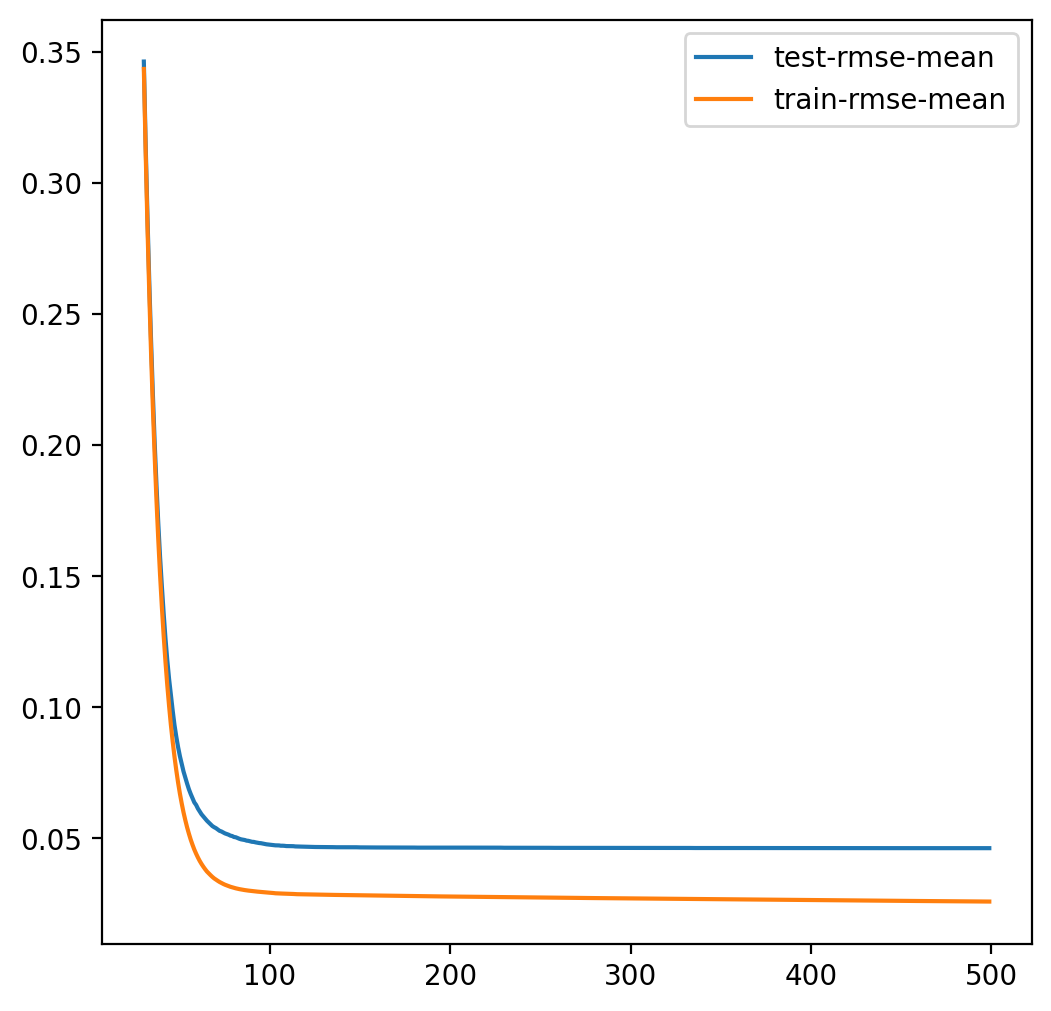

In [27]:
model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()

In [28]:
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1) #the params were tuned using xgb.cv
model_xgb.fit(X_train, y)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=2, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=360, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [29]:
xgb_preds = np.expm1(model_xgb.predict(X_test))
lasso_preds = np.expm1(model_lasso.predict(X_test))

<AxesSubplot: xlabel='xgb', ylabel='lasso'>

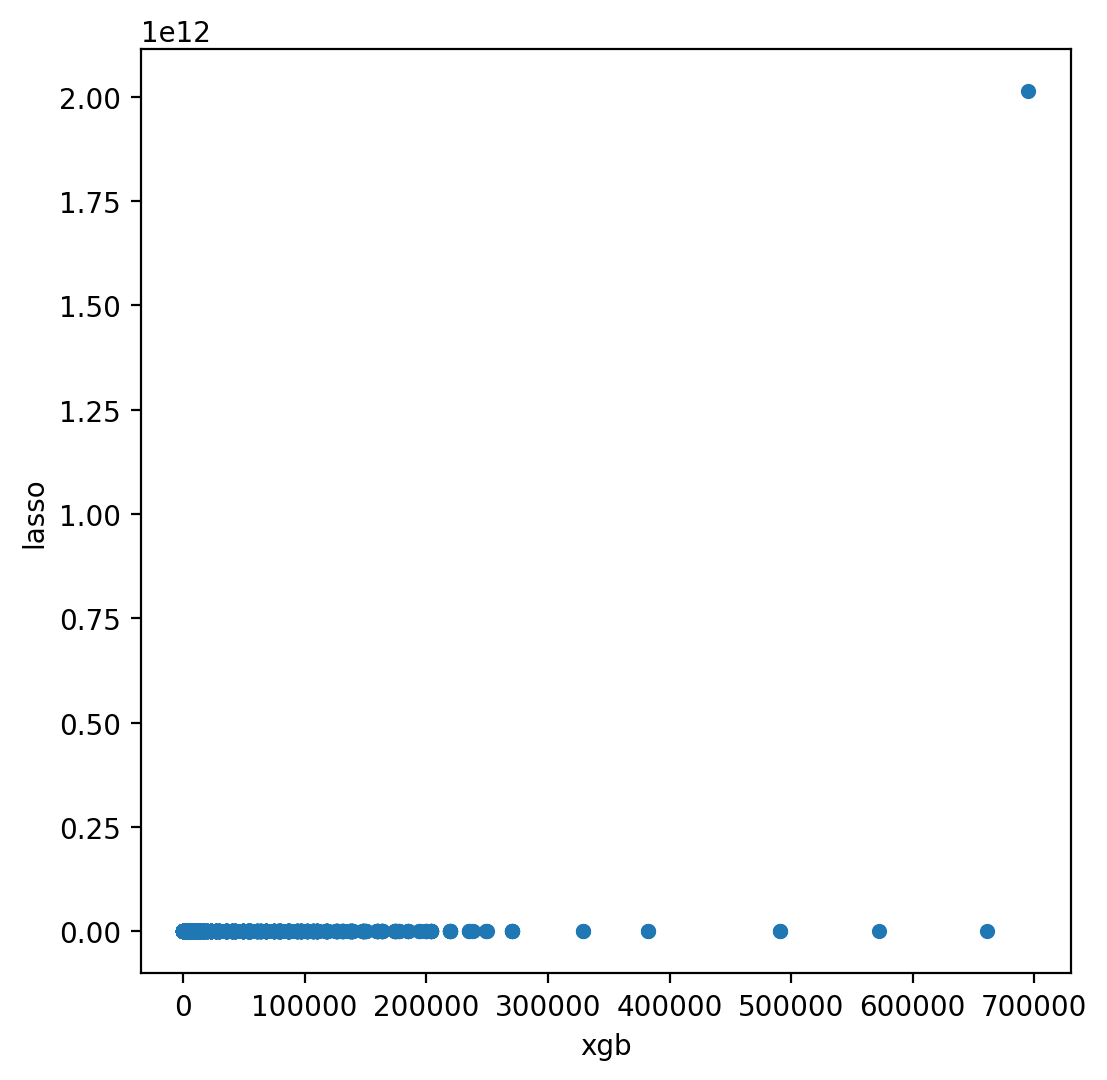

In [30]:
predictions = pd.DataFrame({"xgb":xgb_preds, "lasso":lasso_preds})
predictions.plot(x = "xgb", y = "lasso", kind = "scatter")

In [31]:
preds = 0.7*lasso_preds + 0.3*xgb_preds

In [35]:
solution = pd.DataFrame({"id":test.sequencial_candidato, "votos":preds})
solution.to_csv("../data/ridge_sol.csv", index = False)